In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# load the data
data = pd.read_csv('../data/benchmark_features.csv')

print(data.shape)
display(data.head())


(1321, 61)


,test_Opiate300_0,test_Opiate300_1,test_Opiate300_2,test_Opiate300_3,test_Opiate300_4,survey_opiates_0,survey_opiates_4,meds_methadone_0,meds_buprenorphine_0,meds_methadone_1,...,pex_musculoskeletal,pex_gi_system,pex_extremeties,pex_neurological,pex_gen_appearance,pex_ears_nose_throat,pex_head_neck,pex_cardio,pex_skin,dropout
0,1.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,8.0,0.0,...,abnormal,abnormal,normal,normal,normal,normal,normal,normal,normal,0.0
1,1.0,1.0,1.0,1.0,1.0,30.0,5.0,0.0,8.0,0.0,...,normal,abnormal,normal,normal,abnormal,abnormal,normal,normal,abnormal,0.0
2,1.0,1.0,1.0,1.0,1.0,30.0,9.0,30.0,0.0,170.0,...,normal,normal,normal,normal,normal,normal,normal,normal,abnormal,0.0
3,1.0,1.0,0.0,1.0,1.0,30.0,6.0,0.0,16.0,0.0,...,normal,normal,normal,normal,normal,normal,normal,normal,normal,0.0
4,1.0,1.0,1.0,1.0,1.0,5.0,0.0,0.0,16.0,0.0,...,normal,abnormal,abnormal,normal,abnormal,abnormal,normal,normal,abnormal,1.0


## Import Require Libraries

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, log_loss

# assign X and y
X, y = data.drop('dropout', axis=1), data['dropout']

# print shape
X.shape, y.shape

((1321, 60), (1321,))

## Split the Data
First split into dev and test.  Test should equal 20% of data<br>
Then split the dev data into train and validation.  Validation should equal 20% of data<br>

In [3]:
# split the data to traininig, validation and test sets
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.165, random_state=0)

# split the development set to training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.20, random_state=0)

# print the shape for each dataset
print('Training set:', X_train.shape, y_train.shape)
print('Validation set:', X_val.shape, y_val.shape)
print('Test set:', X_test.shape, y_test.shape)


Training set: (882, 60) (882,)
Validation set: (221, 60) (221,)
Test set: (218, 60) (218,)


## Assign columns to dtype for pipelines

In [4]:
# start with int and float
int_columns = [col for col in X_train.columns if X_train[col].dtype == 'int64']
float_columns = [col for col in X_train.columns if X_train[col].dtype == 'float64']

# Combine both lists if you need columns of both types
numeric_columns = int_columns + float_columns

# get categorical columns
categorical_columns = [col for col in X_train.columns if X_train[col].dtype == 'object']

### Using C-Index as calssification metric

## Implement Pipeline Objects
`make_scorer()` - Create a scorer object<br>
`ColumnTransformer()` - Create a column transformer object<br>
`Pipeline()` - Create a pipeline object<br>
`IterativeImputer()` - Impute missing values<br>
`StandardScaler()` - Scale features<br>
`SimpleImputer()` - Impute missing values<br>
`OneHotEncoder()` - Encode categorical features<br>
`LogisticRegression()` - Logistic Regression model<br>
`RandomForestClassifier()` - Random Forest model<br>
`XGBClassifier()` - XGBoost model<br>
`GridSearchCV()` - Grid Search object<br>
<br>
## Param Grid Configurations

```python
'LogisticRegression': {'classifier__C': [0.1, 1, 10]},
'RandomForest': {'classifier__n_estimators': [200, 300, 400],
                'classifier__max_depth': [3, 5, 10]},
'XGBoost': {'classifier__learning_rate': [0.01, 0.1, 0.3],
                'classifier__n_estimators': [200, 300, 400]}
```

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import make_scorer

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
import helper

# Define the custom scoring function
def cindex_scorer(y_true, y_pred):
    return helper.cindex(y_true, y_pred)

# Create a scorer object
cindex = make_scorer(cindex_scorer, greater_is_better=True)

# Instantiate the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', IterativeImputer(max_iter=10, random_state=0)),
            ('scaler', StandardScaler())
        ]), numeric_columns),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_columns)
    ])

# Define the classifiers
classifiers = {
    'LogisticRegression': LogisticRegression(),
    'RandomForest': RandomForestClassifier(),
    'XGBoost': xgb.XGBClassifier()
}

# Define pipelines for each classifier
pipelines = {
    name: Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', classifier)])
    for name, classifier in classifiers.items()
}

# Define parameter grids for each classifier
param_grids = {
    'LogisticRegression': {'classifier__C': [0.1, 1, 10]},
    'RandomForest': {'classifier__n_estimators': [200, 300, 400], 
                     'classifier__max_depth': [3, 5, 10]},
    'XGBoost': {'classifier__learning_rate': [0.01, 0.1, 0.3],
                'classifier__n_estimators': [200, 300, 400]}
}


# Initialize results storage
results = []

# Run GridSearchCV for each pipeline
for name, pipeline in pipelines.items():
    print(f"Training {name}...")
    grid_search = GridSearchCV(pipeline, param_grids[name], cv=5, scoring=cindex, return_train_score=True)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    y_train_pred = best_model.predict(X_train)
    y_val_pred = best_model.predict(X_val)
    
    train_accuracy = helper.cindex(y_train, y_train_pred)
    val_accuracy = helper.cindex(y_val, y_val_pred)
    
    print(f"{name} - Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    
    results.append({
        'model': name,
        'train_accuracy': train_accuracy,
        'validation_accuracy': val_accuracy,
        'best_params': grid_search.best_params_
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Print the best parameters for each model
for index, row in results_df.iterrows():
    print()
    print(f"Model: {row['model']}")
    print()
    print(f"Best Parameters: {row['best_params']}")
    print()


Training LogisticRegression...
LogisticRegression - Train Accuracy: 0.7800, Validation Accuracy: 0.7382
Training RandomForest...
RandomForest - Train Accuracy: 0.9820, Validation Accuracy: 0.8199
Training XGBoost...
XGBoost - Train Accuracy: 0.9405, Validation Accuracy: 0.8637

Model: LogisticRegression

Best Parameters: {'classifier__C': 0.1}


Model: RandomForest

Best Parameters: {'classifier__max_depth': 10, 'classifier__n_estimators': 300}


Model: XGBoost

Best Parameters: {'classifier__learning_rate': 0.01, 'classifier__n_estimators': 300}



## Now Run the Models on the Unseen Test Data

In [6]:
# run the models on the best parameters and test accuracy on the test set and plot results
results = []

for name, pipeline in pipelines.items():
    best_model = pipeline.set_params(**results_df[results_df['model'] == name]['best_params'].values[0])
    best_model.fit(X_dev, y_dev)
    
    y_test_pred = best_model.predict(X_test)
    test_accuracy = helper.cindex(y_test, y_test_pred)
    
    results.append({
        'model': name,
        'test_accuracy': test_accuracy
    })

    print(f"{name} - Test Accuracy: {test_accuracy:.4f}")

# Convert results to DataFrame
results_df = pd.DataFrame(results)

    

LogisticRegression - Test Accuracy: 0.7112
RandomForest - Test Accuracy: 0.8682
XGBoost - Test Accuracy: 0.8854


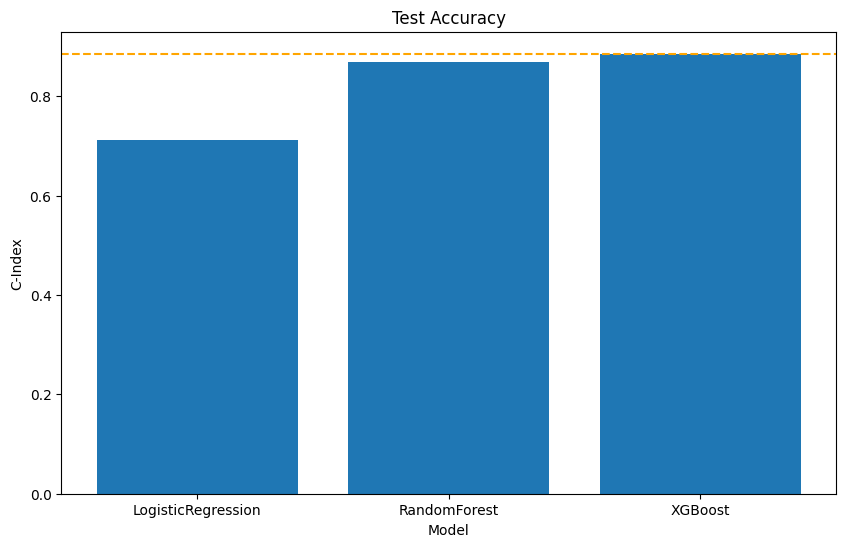

In [8]:
# plot the accuracy on the test set
plt.figure(figsize=(10, 6))
plt.bar(results_df['model'], results_df['test_accuracy'])
plt.title('Test Accuracy')
plt.xlabel('Model')
plt.ylabel('C-Index')
plt.axhline(y=0.8854, color='orange', linestyle='--')
plt.show()


In [14]:
# create pipeline for XGBoost
xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', xgb.XGBClassifier(learning_rate=0.1, n_estimators=300))])

# fit the pipeline on the development set
xgb_pipeline.fit(X_train, y_train)

# predict the test set
y_test_pred = xgb_pipeline.predict(X_test)

# calculate the accuracy on the test set
test_accuracy = helper.cindex(y_test, y_test_pred)
print(f"XGBoost - Test Accuracy: {test_accuracy:.4f}")


XGBoost - Test Accuracy: 0.8433


Sensitivity: 0.7786


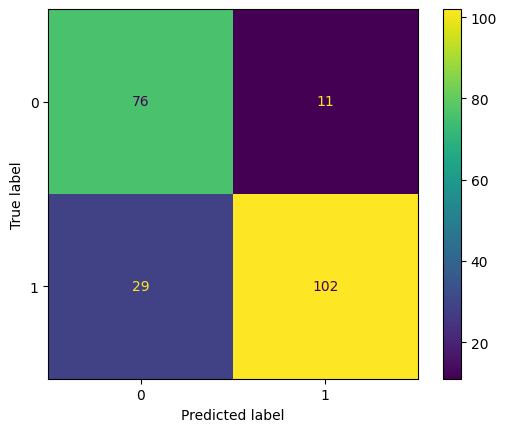

In [34]:
# confusion matrix display
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_pipeline.classes_)
disp.plot();

sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
print(f"Sensitivity: {sensitivity:.4f}")

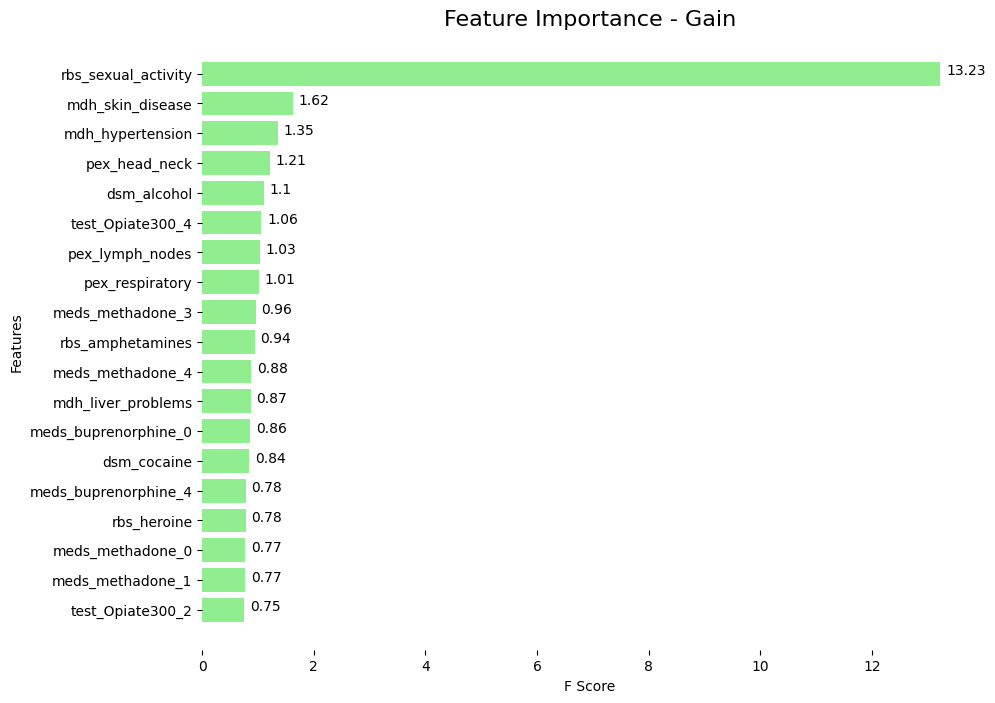

In [23]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Assuming grid_auc.best_estimator_ is your trained XGBoost model
model = xgb_pipeline.named_steps['classifier']

# Ensure feature names are set
feature_names = X_train.columns  # Assuming X_train is your training DataFrame

# Get feature importances and round them
importances = model.get_booster().get_score(importance_type='gain')

# Ensure the feature names are correctly mapped
importances_rounded = {}
for k, v in importances.items():
    index = int(k[1:])
    if index < len(feature_names):
        importances_rounded[feature_names[index]] = round(v, 2)

# Sort features by importance
sorted_importances = sorted(importances_rounded.items(), key=lambda x: x[1], reverse=True)[:19]

# Separate keys and values for plotting
features, scores = zip(*sorted_importances)

# Plot
plt.figure(figsize=(10, 8))
plt.barh(range(len(scores)), scores, color='lightgreen')
plt.yticks(range(len(scores)), features)
plt.xlabel('F Score')
plt.ylabel('Features')
# annotate the values over the bars
for i, v in enumerate(scores):
    plt.text(v + 0.1, i - 0.1, str(v), color='black', va='center')
plt.title(f'Feature Importance - Gain', fontsize=16)
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
# remove borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.show()

In [29]:
# get the names of the top 20 features
top_features = [feature for feature, score in sorted_importances]

new_x, new_y = data[top_features], data['dropout']

# split the data to traininig, validation
X_dev, X_test, y_dev, y_test = train_test_split(new_x, new_y, test_size=0.165, random_state=0)

# split the development set to training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.20, random_state=0)

# print the shape for each dataset
print('Training set:', X_train.shape, y_train.shape)
print('Validation set:', X_val.shape, y_val.shape)
print('Test set:', X_test.shape, y_test.shape)

Training set: (882, 19) (882,)
Validation set: (221, 19) (221,)
Test set: (218, 19) (218,)


In [31]:
# preprocessor for the new data
numeric_columns = [col for col in X_train.columns if X_train[col].dtype != 'object']
categorical_columns = [col for col in X_train.columns if X_train[col].dtype == 'object']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', IterativeImputer(max_iter=10, random_state=0)),
            ('scaler', StandardScaler())
        ]), numeric_columns),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_columns)
    ])

# create the pipeline for XGBoost   
xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', xgb.XGBClassifier(learning_rate=0.1, n_estimators=300))])

# fit the pipeline on the development set
xgb_pipeline.fit(X_train, y_train)

# predict the test set
y_test_pred = xgb_pipeline.predict(X_test)

# calculate the accuracy on the test set
test_accuracy = helper.cindex(y_test, y_test_pred)
print(f"XGBoost - Test Accuracy: {test_accuracy:.4f}")


XGBoost - Test Accuracy: 0.8261
